In [3]:
# %load_ext lab_black

## Imports

In [4]:
import os
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ast import literal_eval
import pickle
import textwrap
import fitz

# Computer Vision
import cv2
from PIL import Image
import skimage.transform as st

# PDF Stuff
from pdf2image import convert_from_path
from PyPDF2 import PdfReader

from dla_pipeline_support_functions import (
    list_files_with_extensions,
    get_filename_without_extension,
    display_images_with_titles,
    generate_rectangular_mask,
    get_mask_bounding_box,
    find_mask_parent,
    find_mask_list_parents,
)

# Pandas display options
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option("display.width", 999)

In [5]:
# Root directory where all the model results are stored
DATA_DIRECTORY = "/user/w210/w210-dev-personal/discrete_model_tests/dit_pipeline/data/s4_dla_results/qasper_dev_DiT_DLA_Results_11-13-2023"

S1_INPUT_PDFS_DIR = join(DATA_DIRECTORY, "s1_input_pdfs")
S2_DLA_INPUTS_DIR = join(DATA_DIRECTORY, "s2_dla_inputs")
S3_OUTPUTS_DIR = join(DATA_DIRECTORY, "s3_outputs")

MODEL_OUTPUTS_DIR = join(S3_OUTPUTS_DIR, "model_outputs")
PAGE_MASKS_DIR = join(S3_OUTPUTS_DIR, "page_masks")

assert os.path.exists(S1_INPUT_PDFS_DIR)
assert os.path.exists(MODEL_OUTPUTS_DIR)
assert os.path.exists(PAGE_MASKS_DIR)

## Support Functions

In [6]:
# Debug, to ensure that the the contents on the individual csvs match the registry one
def valadiate_results_csvs(page_mask_directory):
    try:
        agg_csvs = pd.DataFrame()

        for file in list_files_with_extensions(page_mask_directory, ["csv"]):
            file_name = get_filename_without_extension(file)

            if file_name == "mask_registry":
                mask_registry = pd.read_csv(file)

            else:
                agg_csvs = pd.concat([agg_csvs, pd.read_csv(file)], axis=0)

        agg_csvs.drop("Unnamed: 0", axis=1, inplace=True)
        mask_registry.drop("Unnamed: 0", axis=1, inplace=True)

        agg_csvs.sort_values(["document", "page_no", "mask_id"], inplace=True)
        mask_registry.sort_values(["document", "page_no", "mask_id"], inplace=True)

        # Check that they are the same
        assert len(mask_registry) == len(
            agg_csvs
        ), "The aggregated content of all the individual page csvs and the mask_registry, do not have the same length"
        assert np.array_equal(
            agg_csvs, mask_registry
        ), "The aggregated content of all the individual page csvs and the mask_registry, do not match"

    except Exception as e:
        raise Exception(f"Match error: {e}")


def load_mask_registry(page_mask_directory, validate_csvs=False):
    valadiate_results_csvs(page_mask_directory)
    mask_registry = pd.read_csv(join(page_mask_directory, "mask_registry.csv"))

    mask_registry.sort_values(["document", "page_no", "mask_id"], inplace=True)

    mask_registry = mask_registry[
        [
            "document",
            "page_no",
            "mask_id",
            "category",
            "category_lbl",
            "score",
            "x0",
            "x1",
            "y0",
            "y1",
            "xcf",
            "ycf",
            "column",
            "mask_shape",
            "is_primary",
            "mask_img_file_names",
            "mask_file_names",
        ]
    ]

    mask_registry["mask_shape"] = mask_registry["mask_shape"].apply(
        lambda var: literal_eval(var)
    )

    return mask_registry

## Read Mask Registry

In [7]:
mask_registry = load_mask_registry(PAGE_MASKS_DIR, validate_csvs=False)
document_list = np.unique(mask_registry["document"].values)

print(f"Total number documents: {len(document_list)}")

Total number documents: 280


## Text Extraction

### Select Document and Page

In [8]:
document_file = "1603.09631.pdf"
page_no = 1

In [9]:
page_idx = page_no - 1

# Document
document_name = get_filename_without_extension(document_file)
document_path = join(S1_INPUT_PDFS_DIR, document_file)
document_pdf = fitz.open(document_path)
document_page_count = document_pdf.page_count

# Page Images
BASE_DPI = 70
page_images = [np.array(img) for img in convert_from_path(document_path, dpi=BASE_DPI)]
page_img = page_images[page_idx]

# Masks registry for target document (showing only primary masks)
query = f"document=='{document_file}' & page_no=={page_no} & is_primary == True"
doc_registry = mask_registry.query(query)

#### Document mask registry

In [10]:
doc_registry

,document,page_no,mask_id,category,category_lbl,score,x0,x1,y0,y1,xcf,ycf,column,mask_shape,is_primary,mask_img_file_names,mask_file_names
38713,1603.09631.pdf,1,0,2,title,0.990447,106,468,81,103,287.0,92.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_0.jpg,1603.09631_page_0001_mask_0.pkl
38714,1603.09631.pdf,1,1,1,text,0.932257,201,373,111,132,287.0,121.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_1.jpg,1603.09631_page_0001_mask_1.pkl
38715,1603.09631.pdf,1,2,1,text,0.901478,151,423,121,178,287.0,149.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_2.jpg,1603.09631_page_0001_mask_2.pkl
38716,1603.09631.pdf,1,3,2,title,0.936242,266,313,182,202,289.5,192.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_3.jpg,1603.09631_page_0001_mask_3.pkl
38717,1603.09631.pdf,1,4,1,text,0.981377,46,528,196,258,287.0,227.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_4.jpg,1603.09631_page_0001_mask_4.pkl
38718,1603.09631.pdf,1,5,1,text,0.994069,46,338,261,278,192.0,269.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_5.jpg,1603.09631_page_0001_mask_5.pkl
38719,1603.09631.pdf,1,6,2,title,0.965653,117,213,286,303,165.0,294.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_6.jpg,1603.09631_page_0001_mask_6.pkl
38720,1603.09631.pdf,1,7,1,text,0.947924,46,283,306,513,164.5,409.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_7.jpg,1603.09631_page_0001_mask_7.pkl
38722,1603.09631.pdf,1,9,1,text,0.997547,46,283,507,618,164.5,562.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_9.jpg,1603.09631_page_0001_mask_9.pkl
38723,1603.09631.pdf,1,10,1,text,0.998469,46,283,616,773,164.5,694.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_10.jpg,1603.09631_page_0001_mask_10.pkl


#### Page Image

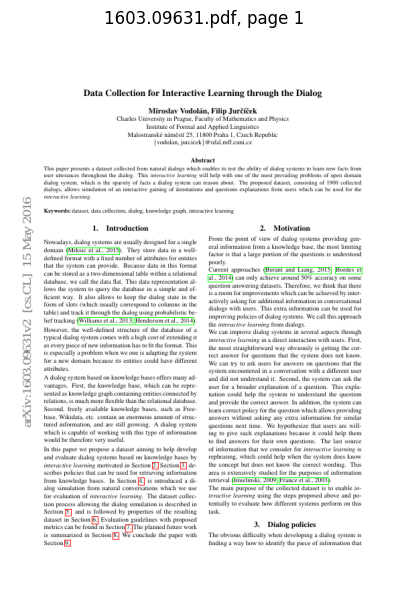

In [11]:
plt.figure(figsize=(5, 8))
plt.imshow(page_img)
plt.axis("off")
plt.title(f"{document_file}, page {page_no}")
plt.show()

### Page dictionary and MuPDF page Scale

In [12]:
# MuPDF Pages
page = document_pdf[page_idx]
page_dict = page.get_text("dict")

# Shape or scale of the PyMuPDF page (converted to int)
mu_pdf_page_shape = np.round((page_dict["height"], page_dict["width"])).astype(int)

#### Generating masks from regitry and re-scaling them to match MuPDF scale

In [13]:
base_masks = []
rescaled_masks = []
rescaled_mask_details = []

for i in range(len(doc_registry)):
    row = doc_registry.iloc[i, :]

    x0 = row["x0"]
    x1 = row["x1"]
    y0 = row["y0"]
    y1 = row["y1"]
    mask_shape = row["mask_shape"]

    # Generating base mask
    mask = generate_rectangular_mask(x0, x1, y0, y1, mask_shape)
    base_masks.append(mask)

    # Rescaling
    rescaled_mask = st.resize(mask, mu_pdf_page_shape, order=0, anti_aliasing=False)
    rescaled_masks.append(rescaled_mask)

    # new bounding box edges
    x0r, x1r, y0r, y1r = get_mask_bounding_box(mask=rescaled_mask, box_buffer=0)

    details_dict = {
        "x0r": x0r,
        "x1r": x1r,
        "y0r": y0r,
        "y1r": y1r,
        "mask_shape_r": rescaled_mask.shape,
    }

    rescaled_mask_details.append(details_dict)

# adding rescaled details to doc_registry
doc_registry = pd.concat(
    [doc_registry, pd.DataFrame(rescaled_mask_details, index=doc_registry.index)],
    axis=1,
)

doc_registry

,document,page_no,mask_id,category,category_lbl,score,x0,x1,y0,y1,xcf,ycf,column,mask_shape,is_primary,mask_img_file_names,mask_file_names,x0r,x1r,y0r,y1r,mask_shape_r
38713,1603.09631.pdf,1,0,2,title,0.990447,106,468,81,103,287.0,92.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_0.jpg,1603.09631_page_0001_mask_0.pkl,109,481,83,106,"(842, 595)"
38714,1603.09631.pdf,1,1,1,text,0.932257,201,373,111,132,287.0,121.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_1.jpg,1603.09631_page_0001_mask_1.pkl,207,383,114,136,"(842, 595)"
38715,1603.09631.pdf,1,2,1,text,0.901478,151,423,121,178,287.0,149.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_2.jpg,1603.09631_page_0001_mask_2.pkl,155,435,124,183,"(842, 595)"
38716,1603.09631.pdf,1,3,2,title,0.936242,266,313,182,202,289.5,192.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_3.jpg,1603.09631_page_0001_mask_3.pkl,273,322,187,208,"(842, 595)"
38717,1603.09631.pdf,1,4,1,text,0.981377,46,528,196,258,287.0,227.0,0,"(819, 579)",True,1603.09631_page_0001_mask_img_4.jpg,1603.09631_page_0001_mask_4.pkl,47,543,202,265,"(842, 595)"
38718,1603.09631.pdf,1,5,1,text,0.994069,46,338,261,278,192.0,269.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_5.jpg,1603.09631_page_0001_mask_5.pkl,47,347,268,286,"(842, 595)"
38719,1603.09631.pdf,1,6,2,title,0.965653,117,213,286,303,165.0,294.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_6.jpg,1603.09631_page_0001_mask_6.pkl,120,219,294,312,"(842, 595)"
38720,1603.09631.pdf,1,7,1,text,0.947924,46,283,306,513,164.5,409.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_7.jpg,1603.09631_page_0001_mask_7.pkl,47,291,315,527,"(842, 595)"
38722,1603.09631.pdf,1,9,1,text,0.997547,46,283,507,618,164.5,562.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_9.jpg,1603.09631_page_0001_mask_9.pkl,47,291,521,635,"(842, 595)"
38723,1603.09631.pdf,1,10,1,text,0.998469,46,283,616,773,164.5,694.5,0,"(819, 579)",True,1603.09631_page_0001_mask_img_10.jpg,1603.09631_page_0001_mask_10.pkl,47,291,633,795,"(842, 595)"


### Getting Page Lines

In [14]:
lines_list = []

for i, block in enumerate(page_dict["blocks"]):
    for ii, line in enumerate(block["lines"]):
        for iii, span in enumerate(line["spans"]):
            span["block"] = i
            span["line"] = ii
            span["pan"] = iii
            lines_list.append(span)

lines_df = pd.DataFrame(lines_list)

# Rouding the coordiantes for for the lines bounding boxes
lines_df["origin"] = lines_df["origin"].apply(
    lambda var: np.round(var, decimals=0).astype(int)
)

lines_df["bbox"] = lines_df["bbox"].apply(
    lambda var: np.round(var, decimals=0).astype(int)
)

lines_df.head(15)

,size,flags,font,color,ascender,descender,text,origin,bbox,block,line,pan
0,14.3462,20,NimbusRomNo9L-Medi,0,0.960,-0.341,Data Collection for Interactive Learning throu...,"[113, 100]","[113, 86, 479, 105]",0,0,0
1,11.9552,20,NimbusRomNo9L-Medi,0,0.960,-0.341,"Miroslav Vodol´an, Filip Jurˇc´ıˇcek","[213, 127]","[213, 115, 379, 131]",1,0,0
2,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"Charles University in Prague, Faculty of Mathe...","[164, 139]","[164, 130, 428, 142]",1,1,0
3,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,Institute of Formal and Applied Linguistics,"[210, 151]","[210, 142, 382, 154]",1,2,0
4,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"Malostransk´e n´amˇest´ı 25, 11800 Praha 1, Cz...","[181, 163]","[181, 153, 411, 166]",1,3,0
5,9.9626,6,CMSY10,0,0.775,-0.960,{,"[220, 175]","[220, 167, 225, 184]",1,4,0
6,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"vodolan, jurcicek","[225, 175]","[225, 165, 294, 177]",1,4,1
7,9.9626,6,CMSY10,0,0.775,-0.960,},"[294, 175]","[294, 167, 299, 184]",1,4,2
8,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,@ufal.mff.cuni.cz,"[299, 175]","[299, 165, 371, 177]",1,4,3
9,9.9626,20,NimbusRomNo9L-Medi,0,0.960,-0.341,Abstract,"[277, 202]","[277, 192, 314, 205]",2,0,0


### Find the masks parents

In [15]:
# Generate a mask for each of the lines in the page
line_mask_list = []

for i in range(len(lines_df)):
    row = lines_df.iloc[i, :]

    x0, y0, x1, y1 = row["bbox"]

    line_mask_list.append(
        generate_rectangular_mask(x0=x0, x1=x1, y0=y0, y1=y1, shape=mu_pdf_page_shape)
    )

# Find the parent masks
parent_mask = find_mask_list_parents(line_mask_list, rescaled_masks)


# Add results to lines_df
lines_df["parent_mask"] = parent_mask

lines_df.head(15)

,size,flags,font,color,ascender,descender,text,origin,bbox,block,line,pan,parent_mask
0,14.3462,20,NimbusRomNo9L-Medi,0,0.960,-0.341,Data Collection for Interactive Learning throu...,"[113, 100]","[113, 86, 479, 105]",0,0,0,0
1,11.9552,20,NimbusRomNo9L-Medi,0,0.960,-0.341,"Miroslav Vodol´an, Filip Jurˇc´ıˇcek","[213, 127]","[213, 115, 379, 131]",1,0,0,1
2,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"Charles University in Prague, Faculty of Mathe...","[164, 139]","[164, 130, 428, 142]",1,1,0,2
3,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,Institute of Formal and Applied Linguistics,"[210, 151]","[210, 142, 382, 154]",1,2,0,2
4,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"Malostransk´e n´amˇest´ı 25, 11800 Praha 1, Cz...","[181, 163]","[181, 153, 411, 166]",1,3,0,2
5,9.9626,6,CMSY10,0,0.775,-0.960,{,"[220, 175]","[220, 167, 225, 184]",1,4,0,2
6,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,"vodolan, jurcicek","[225, 175]","[225, 165, 294, 177]",1,4,1,2
7,9.9626,6,CMSY10,0,0.775,-0.960,},"[294, 175]","[294, 167, 299, 184]",1,4,2,2
8,9.9626,4,NimbusRomNo9L-Regu,0,0.924,-0.281,@ufal.mff.cuni.cz,"[299, 175]","[299, 165, 371, 177]",1,4,3,2
9,9.9626,20,NimbusRomNo9L-Medi,0,0.960,-0.341,Abstract,"[277, 202]","[277, 192, 314, 205]",2,0,0,3


### Display Results

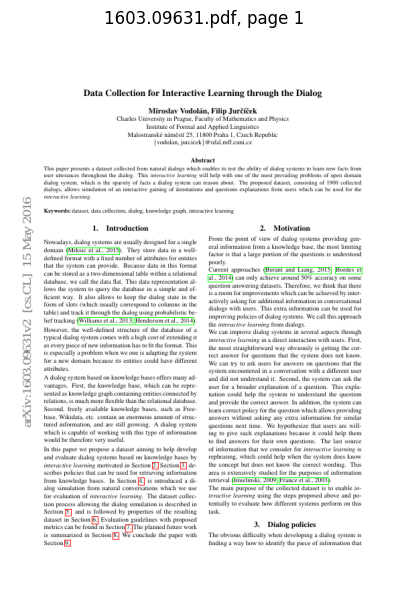

****************************************************************************************************

## MASK ID 0 (title)##


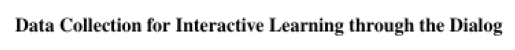

Data Collection for Interactive Learning through the Dialog

****************************************************************************************************

## MASK ID 1 (text)##


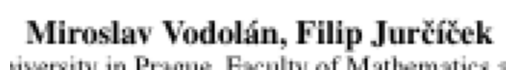

Miroslav Vodol´an, Filip Jurˇc´ıˇcek

****************************************************************************************************

## MASK ID 2 (text)##


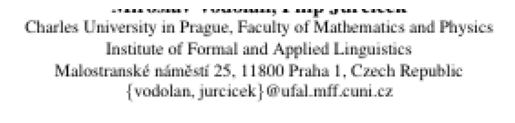

Charles University in Prague, Faculty of Mathematics and Physics Institute of
Formal and Applied Linguistics Malostransk´e n´amˇest´ı 25, 11800 Praha 1, Czech
Republic { vodolan, jurcicek } @ufal.mff.cuni.cz

****************************************************************************************************

## MASK ID 3 (title)##


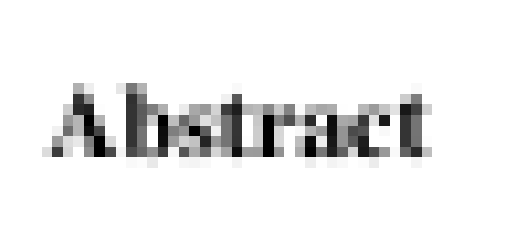

Abstract

****************************************************************************************************

## MASK ID 4 (text)##


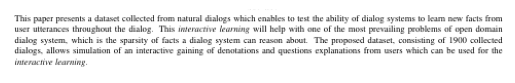

This paper presents a dataset collected from natural dialogs which enables to
test the ability of dialog systems to learn new facts from user utterances
throughout the dialog. This  interactive learning  will help with one of the
most prevailing problems of open domain dialog system, which is the sparsity of
facts a dialog system can reason about. The proposed dataset, consisting of 1900
collected dialogs, allows simulation of an interactive gaining of denotations
and questions explanations from users which can be used for the interactive
learning .

****************************************************************************************************

## MASK ID 5 (text)##


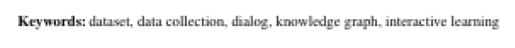

Keywords:  dataset, data collection, dialog, knowledge graph, interactive
learning

****************************************************************************************************

## MASK ID 6 (title)##


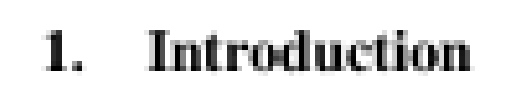

1. Introduction

****************************************************************************************************

## MASK ID 7 (text)##


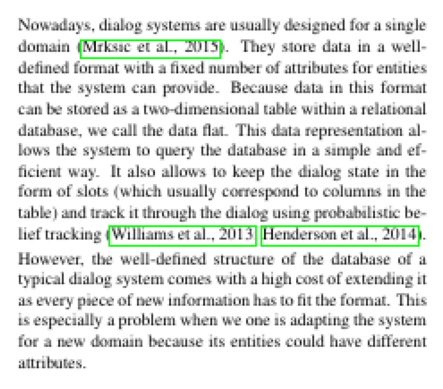

Nowadays, dialog systems are usually designed for a single domain (Mrksic et
al., 2015). They store data in a welldeﬁned format with a ﬁxed number of
attributes for entities that the system can provide. Because data in this format
can be stored as a two-dimensional table within a relational database, we call
the data ﬂat. This data representation allows the system to query the database
in a simple and efﬁcient way. It also allows to keep the dialog state in the
form of slots (which usually correspond to columns in the table) and track it
through the dialog using probabilistic belief tracking (Williams et al., 2013;
Henderson et al., 2014). However, the well-deﬁned structure of the database of a
typical dialog system comes with a high cost of extending it as every piece of
new information has to ﬁt the format. This is especially a problem when we one
is adapting the system for a new domain because its entities could have
different attributes.

*******************************************

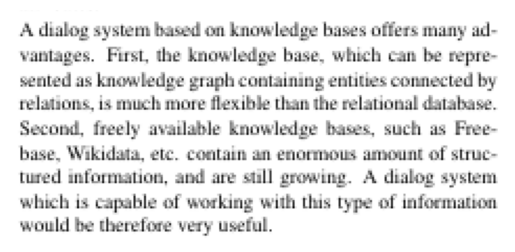

A dialog system based on knowledge bases offers many advantages. First, the
knowledge base, which can be represented as knowledge graph containing entities
connected by relations, is much more ﬂexible than the relational database.
Second, freely available knowledge bases, such as Freebase, Wikidata, etc.
contain an enormous amount of structured information, and are still growing. A
dialog system which is capable of working with this type of information would be
therefore very useful.

****************************************************************************************************

## MASK ID 10 (text)##


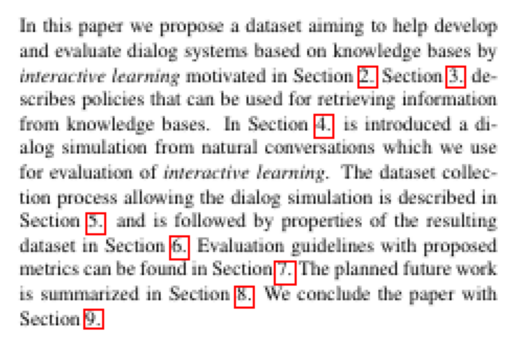

In this paper we propose a dataset aiming to help develop and evaluate dialog
systems based on knowledge bases by interactive learning  motivated in Section
2. Section 3. describes policies that can be used for retrieving information
from knowledge bases. In Section 4. is introduced a dialog simulation from
natural conversations which we use for evaluation of  interactive learning . The
dataset collection process allowing the dialog simulation is described in
Section 5. and is followed by properties of the resulting dataset in Section 6.
Evaluation guidelines with proposed metrics can be found in Section 7. The
planned future work is summarized in Section 8. We conclude the paper with
Section 9.

****************************************************************************************************

## MASK ID 11 (title)##


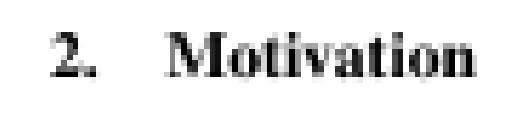

2. Motivation

****************************************************************************************************

## MASK ID 12 (text)##


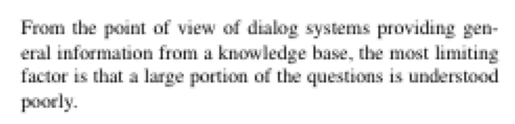

From the point of view of dialog systems providing general information from a
knowledge base, the most limiting factor is that a large portion of the
questions is understood poorly.

****************************************************************************************************

## MASK ID 13 (text)##


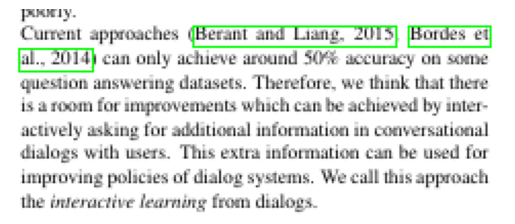

Current approaches (Berant and Liang, 2015; Bordes et al., 2014) can only
achieve around 50% accuracy on some question answering datasets. Therefore, we
think that there is a room for improvements which can be achieved by
interactively asking for additional information in conversational dialogs with
users. This extra information can be used for improving policies of dialog
systems. We call this approach the  interactive learning  from dialogs.

****************************************************************************************************

## MASK ID 14 (text)##


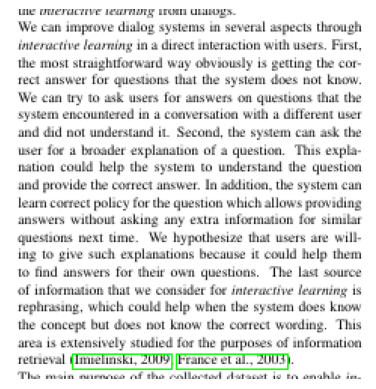

We can improve dialog systems in several aspects through interactive learning
in a direct interaction with users. First, the most straightforward way
obviously is getting the correct answer for questions that the system does not
know. We can try to ask users for answers on questions that the system
encountered in a conversation with a different user and did not understand it.
Second, the system can ask the user for a broader explanation of a question.
This explanation could help the system to understand the question and provide
the correct answer. In addition, the system can learn correct policy for the
question which allows providing answers without asking any extra information for
similar questions next time. We hypothesize that users are willing to give such
explanations because it could help them to ﬁnd answers for their own questions.
The last source of information that we consider for  interactive learning  is
rephrasing, which could help when the system does know the concept but

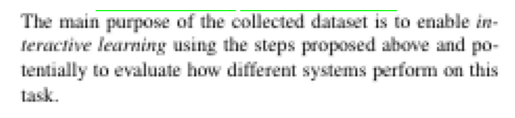

The main purpose of the collected dataset is to enable  interactive learning
using the steps proposed above and potentially to evaluate how different systems
perform on this task.

****************************************************************************************************

## MASK ID 16 (title)##


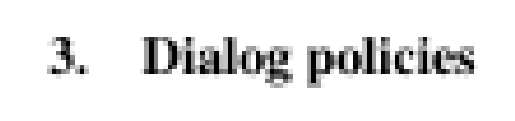

3. Dialog policies

****************************************************************************************************

## MASK ID 17 (text)##


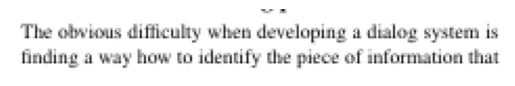

The obvious difﬁculty when developing a dialog system is ﬁnding a way how to
identify the piece of information that

****************************************************************************************************


In [16]:
plt.figure(figsize=(5, 8))
plt.imshow(page_img)
plt.axis("off")
plt.title(f"{document_file}, page {page_no}")
plt.show()

print("*" * 100)

for i in range(len(doc_registry)):

    row = doc_registry.iloc[i, :]

    # Generate DLA images
    x0 = row["x0"]
    x1 = row["x1"]
    y0 = row["y0"]
    y1 = row["y1"]
    mask_shape = row["mask_shape"]

    mask = base_masks[i]
    masked_img = cv2.bitwise_and(page_img, page_img, mask=mask)
    cropped_img = masked_img[y0:y1, x0:x1, :]

    # Get the lines in the lines_df whose parent mask matches the current index
    lines = lines_df.loc[lines_df["parent_mask"] == i]["text"].to_list()
    lines_str = " ".join(lines)

    # Text processing
    lines_str = lines_str.replace("- ", "")

    if lines_str == "":
        lines_str = "**NO TEXT FOUND**"

    # Display
    print(f"\n## MASK ID {row['mask_id']} ({row['category_lbl']})##")

    plt.axis("off")
    plt.imshow(cropped_img)
    plt.show()

    # display(f"{lines_str}")

    print(textwrap.fill(f"{lines_str}", 80))
    print("")
    print("*" * 100)